In [1]:
from json import dumps

import matplotlib.pyplot as plt
import numpy as np
import torch
import transformers
from tqdm.autonotebook import tqdm

import loader
from models import BinningCalibrator
import utils

split_ratio_test = 0.3
split_ratio_postproc = 0.1  # among all training data

# These seeds control the randomness for the post-process/test split and in
# postprocessing.  It does not affect pre-training data nor the randomness in
# pre-training, i.e., we assume the pre-trained predictor to be fixed.  Results
# will be aggregated over the seeds.
seeds = range(33, 38)

# This seed controls the randomness during pre-training (fixed)
seed_pretrain = 33

# Settings for calibration
split_ratio_calib = 0.3
n_bins_calib = 70

max_workers = 4
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

data_dir = "data/biasbios"

In [2]:
## Download BiasBios dataset

(dataset, labels, label_names, groups,
 group_names) = loader.load_biasbios(data_dir, add_sensitive_attribute=True)
dataset_u = loader.load_biasbios(data_dir, add_sensitive_attribute=False)[0]
display(
    loader.dataset_stats(dataset['title'], label_names, dataset['gender'],
                         group_names))

n_classes = len(label_names)
n_groups = len(group_names)

print('example from attribute-aware dataset:',
      dumps(dataset[seed_pretrain], indent=2))
print('example from attribute-blind dataset:',
      dumps(dataset_u[seed_pretrain], indent=2))

Group,female,male
Target,,
accountant,2081,3571
architect,2398,7715
attorney,12494,20113
chiropractor,690,1908
comedian,592,2207
composer,918,4682
dentist,5153,9326
dietitian,3689,289
dj,211,1274


example from attribute-aware dataset: {
  "bio": "Male. He produced scores of films including such as al-Dhareeh (the shrine), 1976, winner of the Cinema Institute Films\u2019 Award at the Documentary and Short Films Festival, Egypt, 1977; as well as the Kelibia Festival Award, Tunisia, 1978; al-Mahatta (The Station), winner of a major award at Oberhausen Short Film Festival, Germany, 1989; the EU Award at FESPACO Festival, Burkina Faso, 1990; The Silver Sword Award at Damascus festival, 1990; and The Silver Tanit Award, Carthage festival, Tunisia, 1991. Eltayeb has served as head of the Sudanese Film group for several terms and as secretary of the Sudanese Film club. He has written numerous articles on cinema, published in major Sudanese newspapers. He is currently working on a long fiction film, al-Siraj wal-attama (The Lantern and Darkness).",
  "title": 9,
  "gender": 1
}
example from attribute-blind dataset: {
  "bio": "He produced scores of films including such as al-Dhareeh (the

In [3]:
## Split data into (test + post-processing) and pre-training sets

split_dataset = dataset.train_test_split(
    test_size=(1 - split_ratio_test) * (1 - split_ratio_postproc),
    seed=seed_pretrain,
)
dataset_ = split_dataset['train']
dataset_pretrain = split_dataset['test']

# Encode the joint (A, Y) labels by flattening
dataset_u = dataset_u.add_column(
    'labels_ay',
    np.array(dataset_u['gender']) * n_classes + np.array(dataset_u['title']))

split_dataset_u = dataset_u.train_test_split(
    test_size=(1 - split_ratio_test) * (1 - split_ratio_postproc),
    seed=seed_pretrain,
)
dataset_u_ = split_dataset_u['train']
dataset_pretrain_u = split_dataset_u['test']

labels_ = np.array(dataset_['title'])
groups_ = np.array(dataset_['gender'])

n_samples = len(dataset)
n_test = int(n_samples * split_ratio_test)

## BERT model

In [4]:
model_name = "bert-base-uncased"

In [5]:
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)


def tokenize_function(examples):
  tokenized_examples = tokenizer(examples["bio"],
                                 padding=False,
                                 max_length=tokenizer.model_max_length,
                                 truncation=True)
  return tokenized_examples


tokenized_dataset_ = dataset_.map(
    tokenize_function,
    batched=True,
    remove_columns=['bio'],
    desc="Running tokenizer",
)
tokenized_dataset_pretrain = dataset_pretrain.map(
    tokenize_function,
    batched=True,
    remove_columns=['bio'],
    desc="Running tokenizer",
)
tokenized_dataset_u_ = dataset_u_.map(
    tokenize_function,
    batched=True,
    remove_columns=['bio'],
    desc="Running tokenizer",
)
tokenized_dataset_pretrain_u = dataset_pretrain_u.map(
    tokenize_function,
    batched=True,
    remove_columns=['bio'],
    desc="Running tokenizer",
)

Running tokenizer:   0%|          | 0/145566 [00:00<?, ? examples/s]

Running tokenizer:   0%|          | 0/247857 [00:00<?, ? examples/s]

Running tokenizer:   0%|          | 0/145566 [00:00<?, ? examples/s]

Running tokenizer:   0%|          | 0/247857 [00:00<?, ? examples/s]

In [6]:
data_collator = transformers.DataCollatorWithPadding(tokenizer)


def train(model, dataset_train, dataset_test, label_col_name, batch_size,
          n_epochs, lr, warmup_ratio, weight_decay, max_grad_norm):

  dataloader_train = torch.utils.data.DataLoader(
      dataset_train,
      shuffle=True,
      collate_fn=data_collator,
      batch_size=batch_size,
  )
  dataloader_test = torch.utils.data.DataLoader(
      dataset_test,
      collate_fn=data_collator,
      batch_size=batch_size,
  )

  no_decay = ["bias", "LayerNorm.weight"]
  optimizer_grouped_parameters = [
      {
          "params": [
              p for n, p in model.named_parameters()
              if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": weight_decay,
      },
      {
          "params": [
              p for n, p in model.named_parameters()
              if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.0
      },
  ]
  optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=lr)
  scheduler = transformers.get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=(warmup_ratio * n_epochs * len(dataloader_train)),
      num_training_steps=n_epochs * len(dataloader_train))

  model_input_args = list(model.forward.__code__.co_varnames)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(n_epochs):

    model.train()
    for batch in tqdm(dataloader_train, desc=f"train epoch {epoch+1}"):
      batch = {k: v.to(device) for k, v in batch.items()}
      optimizer.zero_grad()
      outputs = model(**{
          k: v for k, v in batch.items() if k in model_input_args
      })
      loss = loss_fn(outputs.logits, batch[label_col_name])
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
      optimizer.step()
      scheduler.step()

    model.eval()
    with torch.no_grad():
      test_loss = 0
      test_acc = 0
      for batch in tqdm(dataloader_test, desc=f"test {epoch+1}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**{
            k: v for k, v in batch.items() if k in model_input_args
        })
        probas = outputs.logits
        test_loss += loss_fn(probas, batch[label_col_name]).item()
        probas_y = probas.softmax(dim=1).reshape(len(batch['title']), -1,
                                                 n_classes).sum(dim=1)
        test_acc += (probas_y.argmax(dim=1) == batch['title']).sum().item()
      test_loss /= len(dataset_test['title'])
      test_acc /= len(dataset_test['title'])
      print(
          f"epoch {epoch+1}/{n_epochs}: loss={test_loss:.4f}, acc={test_acc:.4f}"
      )


def predict_probas(model, dataset, batch_size):
  dataloader = torch.utils.data.DataLoader(
      dataset,
      collate_fn=data_collator,
      batch_size=batch_size,
  )
  model_input_args = list(model.forward.__code__.co_varnames)
  model.eval()
  with torch.no_grad():
    probas = []
    for batch in tqdm(dataloader, desc="inference"):
      batch = {
          k: v.to(device) for k, v in batch.items() if k in model_input_args
      }
      outputs = model(**batch)
      probas.append(outputs.logits.softmax(dim=1).cpu().numpy())
    probas = np.concatenate(probas, axis=0)
    return probas

2024-03-05 10:27:50.767288: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-05 10:27:50.828739: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 10:27:51.740701: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Fine-tune BERT

In [7]:
## (Pre-)train predictors

batch_size = 32
n_epochs = 3
lr = 2e-5
warmup_ratio = 0.1
weight_decay = 0.01
max_grad_norm = 1.0

# Train attribute-aware p(Y | X) predictor
transformers.set_seed(seed_pretrain)
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=n_classes).to(device)
train(
    model,
    tokenized_dataset_pretrain,
    tokenized_dataset_.train_test_split(test_size=0.1,
                                        seed=seed_pretrain)['test'],
    'title',
    batch_size,
    n_epochs,
    lr,
    warmup_ratio,
    weight_decay,
    max_grad_norm,
)

# Train attribute-blind p(A, Y | X) predictor
transformers.set_seed(seed_pretrain)
model_u = transformers.AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=n_groups * n_classes).to(device)
train(
    model_u,
    tokenized_dataset_pretrain_u,
    tokenized_dataset_u_.train_test_split(test_size=0.1,
                                          seed=seed_pretrain)['test'],
    'labels_ay',
    batch_size,
    n_epochs,
    lr,
    warmup_ratio,
    weight_decay,
    max_grad_norm,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


train epoch 1:   0%|          | 0/7746 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


test 1:   0%|          | 0/455 [00:00<?, ?it/s]

epoch 1/3: loss=0.0156, acc=0.8526


train epoch 2:   0%|          | 0/7746 [00:00<?, ?it/s]

test 2:   0%|          | 0/455 [00:00<?, ?it/s]

epoch 2/3: loss=0.0146, acc=0.8614


train epoch 3:   0%|          | 0/7746 [00:00<?, ?it/s]

test 3:   0%|          | 0/455 [00:00<?, ?it/s]

epoch 3/3: loss=0.0154, acc=0.8605


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


train epoch 1:   0%|          | 0/7746 [00:00<?, ?it/s]

test 1:   0%|          | 0/455 [00:00<?, ?it/s]

epoch 1/3: loss=0.0158, acc=0.8520


train epoch 2:   0%|          | 0/7746 [00:00<?, ?it/s]

test 2:   0%|          | 0/455 [00:00<?, ?it/s]

epoch 2/3: loss=0.0153, acc=0.8594


train epoch 3:   0%|          | 0/7746 [00:00<?, ?it/s]

test 3:   0%|          | 0/455 [00:00<?, ?it/s]

epoch 3/3: loss=0.0158, acc=0.8599


In [8]:
# Precompute P(A, Y | X) on (test + post-processing) set for aware setting
probas_y_ = predict_probas(model, tokenized_dataset_,
                           128).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predict_probas(model_u, tokenized_dataset_u_,
                              128).reshape(-1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'probas_ay': probas_ay_u_}

inference:   0%|          | 0/1138 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


inference:   0%|          | 0/1138 [00:00<?, ?it/s]

In [9]:
print(
    'Calibration error of attribute-blind predictor:',
    utils.calibration_error(probas_ay_u_.reshape(-1, n_groups * n_classes),
                            groups_ * n_classes + labels_,
                            n_bins=n_bins_calib))

Calibration error of attribute-blind predictor: 1.7358485674272057


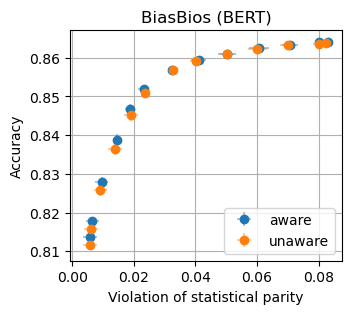

Results for attribute-aware setting:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.864159  0.000346  0.083156  0.000290     0.023233  0.000082
0.080  0.864006  0.000376  0.080139  0.001456     0.022897  0.000189
0.070  0.863366  0.000465  0.070672  0.002480     0.021871  0.000294
0.060  0.862498  0.000554  0.060735  0.003311     0.020843  0.000343
0.050  0.860990  0.000690  0.050214  0.002938     0.019870  0.000283
0.040  0.859311  0.000800  0.041008  0.002559     0.019087  0.000295
0.030  0.856871  0.000838  0.032499  0.000757     0.017474  0.000430
0.020  0.851782  0.001019  0.023189  0.001714     0.013716  0.000592
0.015  0.846798  0.001245  0.018684  0.001551     0.011105  0.000442
0.010  0.838776  0.001396  0.014442  0.001359     0.007981  0.000404
0.005  0.827880  0.001224  0.009591  0.002083     0.004830  0.000276
0.002  0.817701  0.000589  0.006515  0.002049     0.002729  0.000381
0.001  0.813565  0.000627  0.005730  0.002235     0.002183  0.000498

Results for attribute-blind setting:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.863750  0.000425  0.082381  0.000363     0.023045  0.000091
0.080  0.863618  0.000439  0.080081  0.002008     0.022793  0.000259
0.070  0.863149  0.000522  0.070174  0.002632     0.021688  0.000322
0.060  0.862283  0.000688  0.060133  0.003053     0.020640  0.000346
0.050  0.860912  0.000717  0.050166  0.002249     0.019697  0.000265
0.040  0.859265  0.000739  0.040163  0.001894     0.018885  0.000200
0.030  0.856901  0.000992  0.032743  0.000630     0.017445  0.000352
0.020  0.850826  0.001289  0.023499  0.001088     0.013798  0.000491
0.015  0.845166  0.001476  0.019011  0.002379     0.011182  0.000465
0.010  0.836539  0.001668  0.013862  0.002396     0.007977  0.000435
0.005  0.825750  0.001509  0.009081  0.002112     0.004793  0.000346
0.002  0.815739  0.001797  0.006014  0.002288     0.002625  0.000417
0.001  0.811533  0.001255  0.005723  0.002381     0.002116  0.000518

In [10]:
## Post-processing for statistical parity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.015, 0.01, 0.005,
        0.002, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.015, 0.01, 0.005,
        0.002, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_sp', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_sp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("BiasBios (BERT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

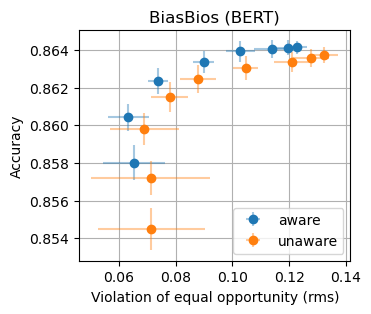

Results for attribute-aware setting:


accuracy           delta_eopp           delta_eopp_rms            \
           mean       std       mean       std           mean       std   
alpha                                                                     
inf    0.864159  0.000346   0.406091  0.015177       0.122912  0.003319   
0.250  0.864132  0.000377   0.375186  0.049533       0.119442  0.005083   
0.200  0.864035  0.000485   0.335496  0.062597       0.113875  0.006392   
0.150  0.863925  0.000544   0.278861  0.044036       0.102770  0.005066   
0.100  0.863357  0.000601   0.221248  0.038116       0.089922  0.003718   
0.050  0.862371  0.000686   0.175577  0.017705       0.073804  0.003400   
0.010  0.860422  0.000707   0.172309  0.045785       0.063234  0.007231   
0.001  0.858011  0.000936   0.197289  0.084379       0.065225  0.010897   

       delta_eo           delta_eo_rms            
           mean       std         mean       std  
alpha                                             
inf    0.406091  0.015177     0.028399  0.000665  
0.250  0.375186  0.049533     0.027784  0.001010  
0.200  0.335496  0.062597     0.026760  0.001274  
0.150  0.278861  0.044036     0.024497  0.000919  
0.100  0.221248  0.038116     0.022087  0.000749  
0.050  0.175577  0.017705     0.018878  0.000525  
0.010  0.172309  0.045785     0.017132  0.001266  
0.001  0.205250  0.076248     0.019960  0.001670

Results for attribute-blind setting:


accuracy           delta_eopp           delta_eopp_rms            \
           mean       std       mean       std           mean       std   
alpha                                                                     
inf    0.863750  0.000425   0.403001  0.016850       0.132246  0.004998   
0.300  0.863567  0.000470   0.385960  0.033164       0.127737  0.006458   
0.250  0.863361  0.000546   0.348455  0.042034       0.120953  0.006435   
0.200  0.863045  0.000652   0.288043  0.039708       0.104640  0.004298   
0.150  0.862473  0.000730   0.232388  0.039584       0.087793  0.006314   
0.100  0.861508  0.000776   0.193961  0.036232       0.077909  0.006510   
0.050  0.859807  0.000824   0.196765  0.071631       0.069040  0.012090   
0.010  0.857203  0.000886   0.227392  0.099461       0.071207  0.020847   
0.001  0.854478  0.001108   0.212924  0.080115       0.071500  0.018936   

       delta_eo           delta_eo_rms            
           mean       std         mean       std  
alpha                                             
inf    0.403001  0.016850     0.030981  0.001145  
0.300  0.385960  0.033164     0.029805  0.001612  
0.250  0.349223  0.040509     0.028430  0.001496  
0.200  0.290499  0.035483     0.025248  0.000788  
0.150  0.232388  0.039584     0.021930  0.001090  
0.100  0.195860  0.032922     0.020199  0.001039  
0.050  0.196765  0.071631     0.018416  0.002088  
0.010  0.227392  0.099461     0.019067  0.003737  
0.001  0.212924  0.080115     0.020160  0.003465

In [11]:
## Post-processing for equal opportunity

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms', 'delta_eo', 'delta_eo_rms'],
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms', 'delta_eo', 'delta_eo_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_eopp_rms', 'accuracy', label='aware')
utils.plot_results(ax,
                   df_blind,
                   'delta_eopp_rms',
                   'accuracy',
                   label='unaware')
ax.set_xlabel("Violation of equal opportunity (rms)")
ax.set_ylabel("Accuracy")
ax.set_title("BiasBios (BERT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

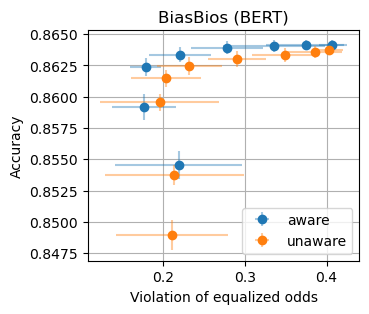

Results for attribute-aware setting:


accuracy           delta_eopp           delta_eopp_rms            \
           mean       std       mean       std           mean       std   
alpha                                                                     
inf    0.864159  0.000346   0.406091  0.015177       0.122912  0.003319   
0.250  0.864132  0.000377   0.375186  0.049533       0.119442  0.005083   
0.200  0.864035  0.000485   0.335496  0.062597       0.113875  0.006392   
0.150  0.863925  0.000544   0.278861  0.044036       0.102770  0.005066   
0.100  0.863357  0.000601   0.221248  0.038116       0.089922  0.003718   
0.050  0.862368  0.000702   0.179116  0.018658       0.074000  0.003591   
0.010  0.859184  0.001075   0.176425  0.040046       0.063330  0.008319   
0.001  0.854520  0.001105   0.219278  0.077400       0.064882  0.015405   

       delta_eo           delta_eo_rms            
           mean       std         mean       std  
alpha                                             
inf    0.406091  0.015177     0.028399  0.000665  
0.250  0.375186  0.049533     0.027784  0.001010  
0.200  0.335496  0.062597     0.026760  0.001274  
0.150  0.278861  0.044036     0.024497  0.000919  
0.100  0.221248  0.038116     0.022087  0.000749  
0.050  0.179116  0.018658     0.018936  0.000561  
0.010  0.177138  0.038814     0.016521  0.001592  
0.001  0.219278  0.077400     0.016831  0.002309

Results for attribute-blind setting:


accuracy           delta_eopp           delta_eopp_rms            \
           mean       std       mean       std           mean       std   
alpha                                                                     
inf    0.863750  0.000425   0.403001  0.016850       0.132246  0.004998   
0.300  0.863567  0.000470   0.385960  0.033164       0.127737  0.006458   
0.250  0.863361  0.000546   0.348455  0.042034       0.120953  0.006435   
0.200  0.863045  0.000652   0.288043  0.039708       0.104640  0.004298   
0.150  0.862473  0.000730   0.232388  0.039584       0.087793  0.006314   
0.100  0.861459  0.000719   0.201746  0.045609       0.078005  0.006733   
0.050  0.859548  0.000703   0.196362  0.072471       0.068145  0.012652   
0.010  0.853746  0.000770   0.205752  0.095283       0.068547  0.021570   
0.001  0.848928  0.001201   0.208269  0.072931       0.073613  0.023006   

       delta_eo           delta_eo_rms            
           mean       std         mean       std  
alpha                                             
inf    0.403001  0.016850     0.030981  0.001145  
0.300  0.385960  0.033164     0.029805  0.001612  
0.250  0.349223  0.040509     0.028430  0.001496  
0.200  0.290499  0.035483     0.025248  0.000788  
0.150  0.232388  0.039584     0.021930  0.001090  
0.100  0.203645  0.042595     0.020222  0.001044  
0.050  0.196362  0.072471     0.017922  0.001855  
0.010  0.214078  0.085093     0.017200  0.003262  
0.001  0.211253  0.068755     0.017799  0.003534

In [12]:
## Post-processing for equalized odds

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms', 'delta_eo', 'delta_eo_rms'],
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms', 'delta_eo', 'delta_eo_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_eo', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_eo', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("BiasBios (BERT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

## Fine-tune BERT and calibrate

In [13]:
split_dataset = tokenized_dataset_pretrain_u.train_test_split(
    test_size=split_ratio_calib, seed=seed_pretrain)
tokenized_dataset_train_u = split_dataset['train']
tokenized_dataset_calib = split_dataset['test']

In [14]:
## (Pre-)train predictors

batch_size = 32
n_epochs = 3
lr = 2e-5
warmup_ratio = 0.1
weight_decay = 0.01
max_grad_norm = 1.0

# Train attribute-blind p(A, Y | X) predictor
transformers.set_seed(seed_pretrain)
model_u = transformers.AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=n_groups * n_classes).to(device)
train(
    model_u,
    tokenized_dataset_train_u,
    tokenized_dataset_u_.train_test_split(test_size=0.1,
                                          seed=seed_pretrain)['test'],
    'labels_ay',
    batch_size,
    n_epochs,
    lr,
    warmup_ratio,
    weight_decay,
    max_grad_norm,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


train epoch 1:   0%|          | 0/5422 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


test 1:   0%|          | 0/455 [00:00<?, ?it/s]

epoch 1/3: loss=0.0164, acc=0.8488


train epoch 2:   0%|          | 0/5422 [00:00<?, ?it/s]

test 2:   0%|          | 0/455 [00:00<?, ?it/s]

epoch 2/3: loss=0.0156, acc=0.8536


train epoch 3:   0%|          | 0/5422 [00:00<?, ?it/s]

test 3:   0%|          | 0/455 [00:00<?, ?it/s]

epoch 3/3: loss=0.0161, acc=0.8590


In [15]:
# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
raw_probas_ay_u_ = predict_probas(model_u, tokenized_dataset_u_, 128)
raw_probas_ay_u_calib = predict_probas(model_u, tokenized_dataset_calib, 128)

inference:   0%|          | 0/1138 [00:00<?, ?it/s]

inference:   0%|          | 0/581 [00:00<?, ?it/s]

In [16]:
# Train p(A, Y | X) calibrator
calib = BinningCalibrator(n_bins_calib, random_state=seed_pretrain)
calib.fit(raw_probas_ay_u_calib, np.array(tokenized_dataset_calib['labels_ay']));

In [17]:
# Calibrate P(A, Y | X) on (test + post-processing) set
probas_ay_u_ = calib.predict_proba(raw_probas_ay_u_).reshape(
    -1, n_groups, n_classes)

postprocess_u_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_u_,
    'max_workers': max_workers,
}

  0%|          | 0/65 [00:00<?, ?it/s]

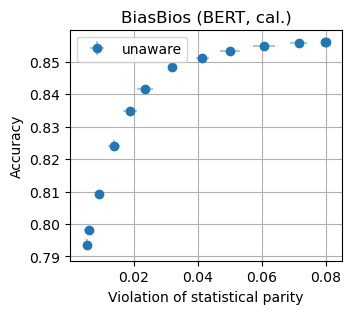

Results for attribute-blind setting:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.856201  0.000412  0.080079  0.000399     0.022518  0.000081
0.080  0.856174  0.000419  0.079654  0.001322     0.022471  0.000179
0.070  0.855618  0.000439  0.071421  0.002682     0.021639  0.000271
0.060  0.854761  0.000548  0.060696  0.003459     0.020846  0.000260
0.050  0.853227  0.000578  0.050088  0.003026     0.020260  0.000179
0.040  0.851273  0.000739  0.041452  0.002077     0.019705  0.000104
0.030  0.848423  0.000862  0.031869  0.000890     0.018322  0.000159
0.020  0.841464  0.000794  0.023544  0.002389     0.014171  0.000387
0.015  0.834723  0.001319  0.018824  0.002135     0.011233  0.000511
0.010  0.824125  0.001653  0.013807  0.001823     0.008082  0.000403
0.005  0.809332  0.001244  0.009062  0.001059     0.004660  0.000304
0.002  0.798082  0.001043  0.005993  0.001597     0.002580  0.000352
0.001  0.793579  0.001665  0.005616  0.001518     0.002089  0.000490

In [18]:
## Post-processing for statistical parity

df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.015, 0.01, 0.005,
        0.002, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_sp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("BiasBios (BERT, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/55 [00:00<?, ?it/s]

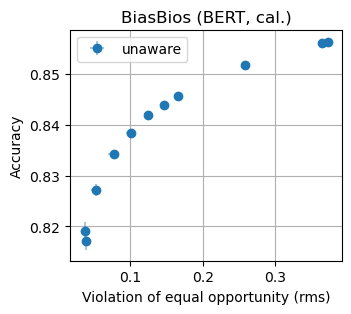

Results for attribute-blind setting:


accuracy           delta_eopp           delta_eopp_rms            \
           mean       std       mean       std           mean       std   
alpha                                                                     
inf    0.856201  0.000412   0.859382  0.006759       0.372853  0.001254   
0.800  0.856001  0.000411   0.805001  0.024732       0.364264  0.003524   
0.500  0.851816  0.000271   0.577219  0.024269       0.257541  0.005524   
0.300  0.845615  0.000727   0.369879  0.024024       0.165975  0.006183   
0.250  0.843897  0.000659   0.321323  0.023465       0.146300  0.004235   
0.200  0.841820  0.000614   0.272476  0.029137       0.124053  0.005527   
0.150  0.838459  0.000301   0.225314  0.040660       0.100598  0.007214   
0.100  0.834167  0.000714   0.176605  0.042031       0.076713  0.007699   
0.050  0.827103  0.001196   0.137344  0.020677       0.052093  0.006318   
0.010  0.819096  0.001757   0.109834  0.024795       0.037845  0.003840   
0.001  0.817040  0.001722   0.127311  0.025638       0.038456  0.004429   

       delta_eo           delta_eo_rms            
           mean       std         mean       std  
alpha                                             
inf    0.859382  0.006759     0.090766  0.000399  
0.800  0.805001  0.024732     0.085535  0.001062  
0.500  0.579388  0.025368     0.063110  0.002365  
0.300  0.753323  0.030323     0.059263  0.001235  
0.250  0.793344  0.029298     0.060820  0.000810  
0.200  0.799225  0.022594     0.061012  0.000847  
0.150  0.800179  0.021908     0.060653  0.001081  
0.100  0.800179  0.021908     0.061203  0.000602  
0.050  0.801108  0.022548     0.062064  0.001990  
0.010  0.802063  0.021952     0.067667  0.003738  
0.001  0.803543  0.020597     0.068213  0.003336

In [19]:
## Post-processing for equal opportunity

df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.8, 0.5, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms', 'delta_eo', 'delta_eo_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_blind,
                   'delta_eopp_rms',
                   'accuracy',
                   label='unaware')
ax.set_xlabel("Violation of equal opportunity (rms)")
ax.set_ylabel("Accuracy")
ax.set_title("BiasBios (BERT, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

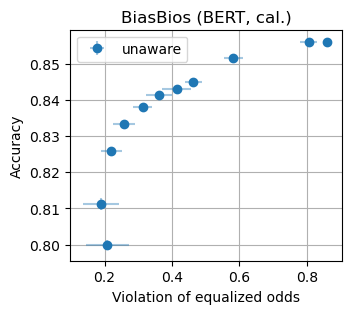

Results for attribute-blind setting:


accuracy           delta_eopp           delta_eopp_rms            \
           mean       std       mean       std           mean       std   
alpha                                                                     
inf    0.856201  0.000412   0.859382  0.006759       0.372853  0.001254   
0.800  0.856001  0.000411   0.805001  0.024732       0.364264  0.003524   
0.500  0.851814  0.000274   0.577219  0.024269       0.257508  0.005500   
0.300  0.845093  0.000587   0.377735  0.029784       0.165059  0.006222   
0.250  0.843182  0.000674   0.341663  0.022674       0.144997  0.006943   
0.200  0.841416  0.000690   0.307541  0.025356       0.127835  0.007207   
0.150  0.838071  0.000388   0.251290  0.029484       0.102666  0.005007   
0.100  0.833318  0.000575   0.173101  0.041253       0.075173  0.008051   
0.050  0.825855  0.001298   0.136332  0.031932       0.051252  0.008171   
0.010  0.811208  0.001564   0.106063  0.043276       0.037212  0.009782   
0.001  0.799831  0.001414   0.097795  0.026004       0.038196  0.007396   

       delta_eo           delta_eo_rms            
           mean       std         mean       std  
alpha                                             
inf    0.859382  0.006759     0.090766  0.000399  
0.800  0.805001  0.024732     0.085523  0.001063  
0.500  0.582205  0.028011     0.063123  0.002379  
0.300  0.462466  0.025308     0.044513  0.001613  
0.250  0.413338  0.042185     0.040524  0.002058  
0.200  0.360343  0.038568     0.036794  0.001869  
0.150  0.313076  0.028181     0.031788  0.001554  
0.100  0.257253  0.032722     0.027212  0.001822  
0.050  0.220383  0.032116     0.021707  0.001722  
0.010  0.188214  0.053383     0.018450  0.001924  
0.001  0.208036  0.063534     0.018834  0.001613

In [20]:
## Post-processing for equalized odds

df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.8, 0.5, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms', 'delta_eo', 'delta_eo_rms'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_eo', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("BiasBios (BERT, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)